# Lesson 7 - Topology of time series

> How ideas from dynamical systems and topological data analysis can be combined to gain insights from time-varying data.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/hepml/master?urlpath=lab/tree/notebooks%2Flesson07_topological-time-series.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson07_topological-time-series.ipynb)

## Learning objectives

## References

* [_Sliding Windows and Persistence: An Application of Topological Methods to Signal Analysis_](https://arxiv.org/abs/1307.6188) by J. Perea and J.Harer
* [_Detection of gravitational waves using topological data analysis and convolutional
neural network: An improved approach_](https://arxiv.org/pdf/1910.08245.pdf) by C. Bresten and J.H.Jung. We thank C. Bresten for sharing the code and data used in the article.

## Why topology for time series?

In time series analysis it is common to represent the signal of interest as a real-valued function over some bounded domain $I$ that represents time:

$$ f: I \to \mathbb{R}$$

One of the most important tasks in time series analysis is the ability to make predictions, e.g. given the temperature now, what will be the temperature in 5 minutes? One way to tackle this question is to identify _**recurrent**_ patterns in $f$. The goal of this lesson is to show how one can use tools from topological data analysis to answer these type of questions.

Let's see a preview of how this might work. Given a positive real number $\tau$ and a positive integer $M$, the _**sliding window embedding**_ of $f$ with parameters $(M,\tau)$ is the function

$$
SW_{M,\tau} f : \mathbb{R} \to \mathbb{R}^{M+1}\,, \qquad t \to \begin{bmatrix}
           f(t) \\
           f(t + \tau) \\
           f(t + 2\tau) \\
           \vdots \\
           f(t + M\tau)
         \end{bmatrix}
$$

The main idea we will explore in this notebook is that if $f$ has a non-trivial recurrent structure, then the image of $SW_{M,\tau}f$ will have non-trivial topology for appropriate choices of $(M, \tau)$.

## Import libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# uncomment this if running locally or on Google Colab
# !pip install --upgrade hepml

In [ ]:
# data wrangling
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import YouTubeVideo

# tda magic
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.plotting import plot_heatmap, plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding

# ml tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, roc_auc_score

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

## From time series to sliding window embeddings

The first step in analysing the topology of time series is to construct a so-called _**sliding window embedding**_, invented by Takens in the 1960s. As shown in the diagram below, a sliding window embedding of a signal can be thought of as sliding a "window" of fixed size over a signal, with each window represented as a point in a (possibly) higher-dimensional space:

![](images/sliding_window_embedding.png)
<div style="text-align: center">
   <p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/3easx09 </p>
</div>


More formally: given a time series $f(t)$, one can extract a _**sequence of vectors**_ of the form $f_i = [(f(t_i)), f(t_i + 2 \tau), \ldots, f(t_i + M \tau)] \in \mathbb{R}^{M+1}$, where $M$ is the _**embedding dimension**_ and $\tau$ is the _**time delay**_. The quantity $M\tau$ is known as the "window size" and the difference between $t_{i+1}$ and $t_i$ is called the **_stride_**.

The sliding window allows us to apply Takens' embedding _**locally**_ on a certain interval rather than over the whole time series. The result of this procedure is a _**time series of point clouds**_ with possibly interesting topologies. These topologies can be used to classify whether a signal is periodic or not.

## A periodic example

As a warm-up, recall that a function is periodic with period $T > 0$ if $f(t + T) = f(t)$ for all $t \in \mathbb{R}$. For example, consider the function $f(t) = \cos(5 t)$ which can be visualised as follows:

In [ ]:
x_periodic = np.linspace(0, 10, 1000)
y_periodic = np.cos(5 * x_periodic)

print(f"Number of time steps: {len(y_periodic)}")

Number of time steps: 1000


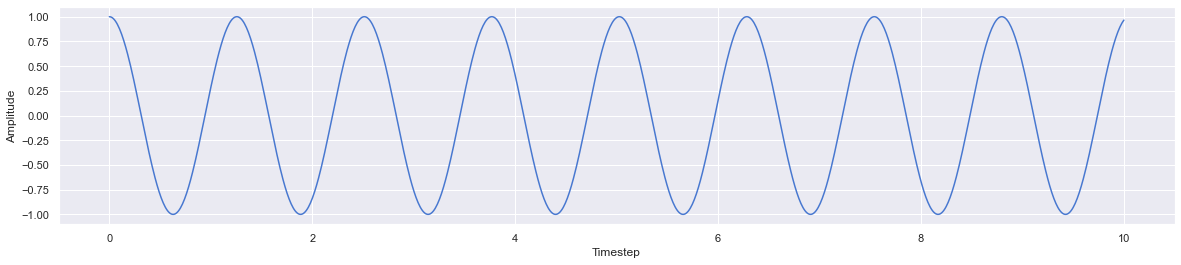

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(x_periodic, y_periodic)
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.show()

We can show that periodicity implies circularity of the sliding window embedding. To do that we need to specify the embedding dimension $M$ and the time delay $\tau$ for the Takens embedding:

In [ ]:
embedding_dimension_periodic = 3
embedding_time_delay_periodic = 8

embedder_periodic = TakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=10,
)

> Tip: You can use the `stride` parameter to downsample the sliding window embedding. This is handy when you want to quickly compute persistence diagrams on a dense signal.

Let's apply this embedding to our time series to get a _new_ time series:

In [ ]:
y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
y_periodic_embedded.shape

(99, 3)

We have gone from a one-dimensional series to a 3-dimensional one, so let's visualise the sliding window embedding as a point cloud:

In [ ]:
plot_point_cloud(y_periodic_embedded)

As promised, the periodicity of $f$ is reflected in the circularity of the sliding window embedding! It turns out that in general, _**periodic functions trace out ellipses**_ in $\mathbb{R}^{M+1}$. 

## A non-periodic example

Here is another type of recurrent behaviour: if we let $f(t) = \cos(t) + \cos(\pi t)$ then it follows that $f$ is not periodic, but its graph certainly depicts recurrent behaviour:

In [ ]:
x_nonperiodic = np.linspace(0, 50, 1000)
y_nonperiodic = np.cos(x_nonperiodic) + np.cos(np.pi * x_nonperiodic)

print(f"Number of time steps: {len(y_nonperiodic)}")

Number of time steps: 1000


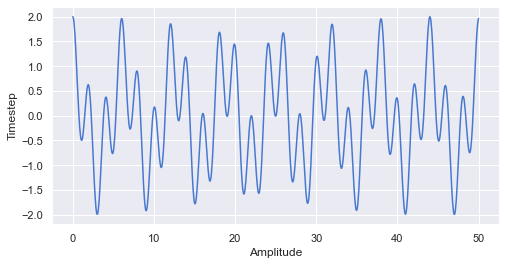

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(x_nonperiodic, y_nonperiodic)
plt.xlabel("Amplitude")
plt.ylabel("Timestep")
plt.show()

As before, let's create a sliding window embedding for this signal and visualise the resulting point cloud:

In [ ]:
embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 16

embedder_nonperiodic = TakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=3,
)

In [ ]:
y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y_nonperiodic)
y_nonperiodic_embedded.shape

(323, 3)

In [ ]:
plot_point_cloud(y_nonperiodic_embedded)

### Exercise
How does the window size $M\tau$ affect the geometry of $SW_{M,\tau}f$ for non-periodic functions? Try changing the values above to gain some intuition.

## From sliding window embeddings to persistence diagrams

In the examples above we saw that the resulting point clouds appear to exhibit distinct topology. We can verify this explicitly using persistent homology! First we need to reshape our point cloud arrays in a form suitable for the Vietoris-Rips construction, namely `(n_samples, n_points, n_dimensions)`:

In [ ]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

# check shapes
y_periodic_embedded.shape, y_nonperiodic_embedded.shape

((1, 99, 3), (1, 323, 3))

The next step is to calculate the persistence diagrams associated with each point cloud:

In [ ]:
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
%time periodic_persistence_diagrams = periodic_persistence.fit_transform(y_periodic_embedded)

CPU times: user 23.4 ms, sys: 49.7 ms, total: 73 ms
Wall time: 847 ms


In [ ]:
nonperiodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
%time nonperiodic_persistence_diagrams = nonperiodic_persistence.fit_transform(y_nonperiodic_embedded)

CPU times: user 3.7 ms, sys: 1.39 ms, total: 5.09 ms
Wall time: 5.71 s


Let's now compare the two diagrams, first for the periodic signal:

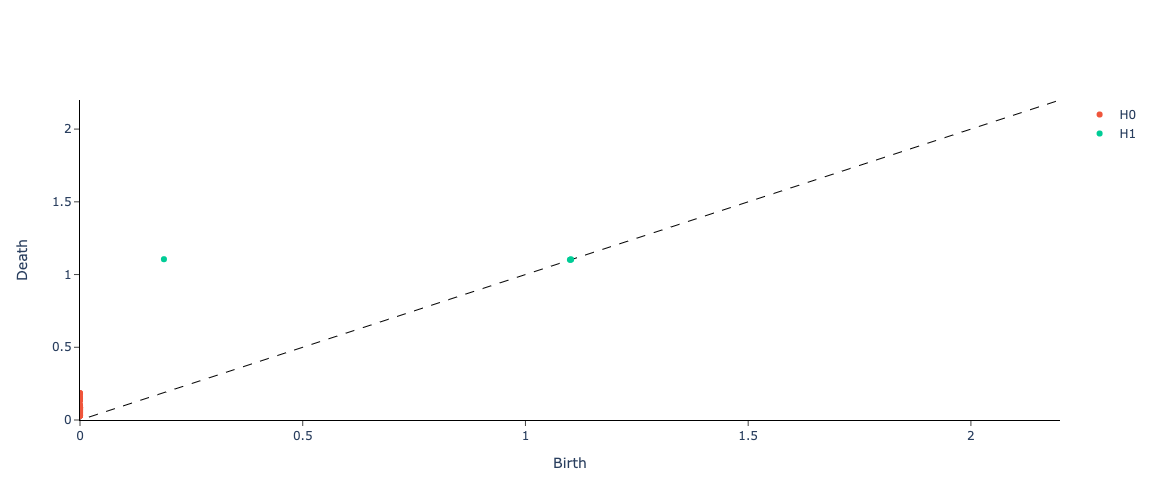

In [ ]:
plot_diagram(periodic_persistence_diagrams[0])

and next for the non-periodic one:

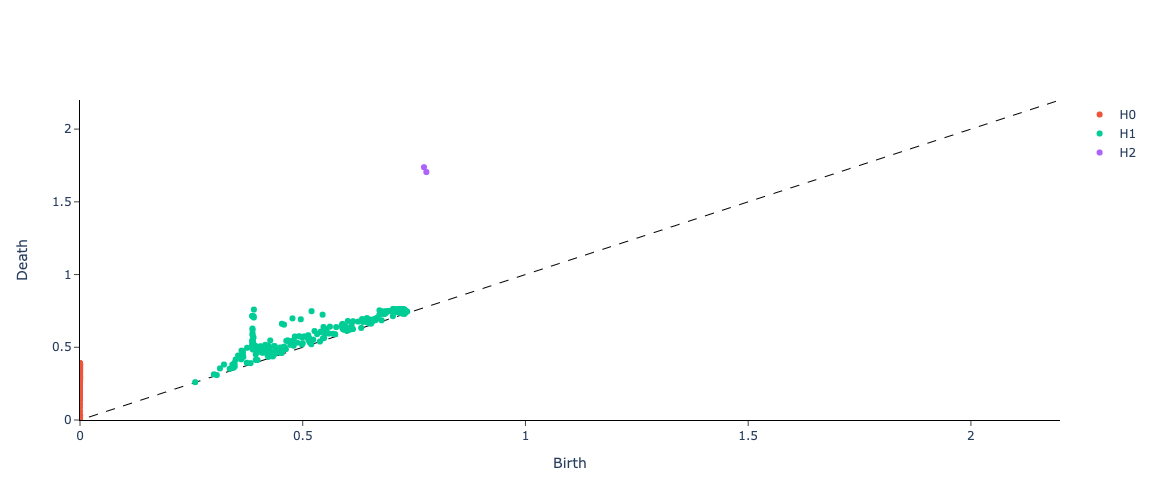

In [ ]:
plot_diagram(nonperiodic_persistence_diagrams[0])

What can conclude from these diagrams? The first thing that stands out is the different types of homology dimensions that are most persistent. In the periodic case we see a single point associated with 1-dimensional persistent homology, namely a loop! On the other hand, the non-periodic signal has revealed two points associated with 2-dimensional peristent homology, namely _voids_. These clear differences in topology make the sliding window embedding technique especially powerful at classifying different time series.

## Picking the embedding dimension and time delay

In the examples above, we manually chose values for the embedding dimension $M$ and time delay $\tau$. However, it turns out there are two techniques that can be used to determine these parameters _automatically_:

* [Mutual information](https://en.wikipedia.org/wiki/Mutual_information) to determine $\tau$
* [False nearest neighbours](https://en.wikipedia.org/wiki/False_nearest_neighbor_algorithm) to determine $M$

In giotto-tda, these techniques are applied when we select `parameters_type="search"` in `TakensEmbedding`, e.g.

```python
embedder = TakensEmbedding(
    parameters_type="search", time_delay=time_delay, dimension=embedding_dimension,
)
```

where the values of `time_delay` and `embedding_dimension` provide _**upper bounds**_ on the search algorithm. Before applying this to our sample signals, let's have a look at how these methods actually work under the hood.

### Mutual information
To determine an optimal value for $\tau$ we first calculate the maximum $x_\mathrm{max}$ and minimum $x_\mathrm{min}$ values of the time series, and divide the interval $[x_\mathrm{min}, x_\mathrm{max}]$ into a large number of bins. We let $p_k$ be the probability that an element of the time series is in the $k$th bin and let $p_{j,k}$ be the probability that $x_i$ is in the $j$th bin while $x_{i+\tau}$ is in the $k$th bin. Then the mutual information is defined as:

$$ I(\tau) = - \sum_{j=1}^{n_\mathrm{bins}} \sum_{k=1}^{n_\mathrm{bins}} p_{j,k}(\tau) \log \frac{p_{j,k}(\tau)}{p_j p_k} $$

The first minimum of $I(\tau)$ gives the optimal delay since there we get the most information by adding $x_{i+\tau}$.

### False nearest neighbours

The false nearest neighbours algorithm is based on the assumption that "unfolding" or embedding a deterministic system into successively higher dimensions is smooth. In other words, points which are close in one embedding dimension should be close in a higher one. More formally, if we have a point $p_i$ and neighbour $p_j$, we check if the normalised distance $R_i$ for the next dimension is greater than some threshold $R_\mathrm{th}$:

$$ R_i = \frac{\mid x_{i+m\tau} - x_{j+m\tau} \mid}{\lVert p_i - p_j \rVert} > R_\mathrm{th}$$

If $R_i > R_\mathrm{th}$ then we have a "false nearest neighbour" and the optimal embedding dimension is obtained by minimising the total number of such neighbours.

### Running the search algorithm

Let's now apply these ideas to our original signals to see what the algorithm determines as optimal choices for $M$ and $\tau$. We will allow the search to scan up to relatively large values of $(M, \tau)$ to ensure we do not get stuck in a sub-optimal minimum.

For the periodic signal, we initialise the Takens embedding as follows:

In [ ]:
max_embedding_dimension = 10
max_time_delay = 30
stride = 5

embedder_periodic = TakensEmbedding(
    parameters_type="search", time_delay=max_time_delay, dimension=max_embedding_dimension, stride=stride
)

Let's create a helper function to view the optimal values found during the search:

In [ ]:
def fit_embedder(embedder, y, verbose=True):
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}")

    return y_embedded

In [ ]:
y_periodic_embedded = fit_embedder(embedder_periodic, y_periodic)

Shape of embedded time series: (171, 6)
Optimal embedding dimension is 6 and time delay is 29


Although the resulting embedding is in 10-dimensions, we can apply [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to project down to 3-dimensions for visualisation:

In [ ]:
pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)

plot_point_cloud(y_periodic_embedded_pca)

Now for the non-periodic case we have:

In [ ]:
embedder_nonperiodic = TakensEmbedding(
    parameters_type="search", n_jobs=2, time_delay=max_time_delay, dimension=max_embedding_dimension, stride=stride,
)

In [ ]:
y_nonperiodic_embedded = fit_embedder(embedder_nonperiodic, y_nonperiodic)

Shape of embedded time series: (186, 6)
Optimal embedding dimension is 6 and time delay is 14


As before we can use PCA to project down to 3-dimensions for visualisation:

In [ ]:
pca = PCA(n_components=3)
y_nonperiodic_embedded_pca = pca.fit_transform(y_nonperiodic_embedded)

plot_point_cloud(y_nonperiodic_embedded_pca)

So we have embedding point clouds whose geometry looks clearly distinct; how about the persistence digrams?

In [ ]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

# check shapes
y_periodic_embedded.shape, y_nonperiodic_embedded.shape

((1, 171, 6), (1, 186, 6))

The next step is to calculate the persistence diagrams associated with each point cloud:

In [ ]:
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
%time periodic_persistence_diagrams = periodic_persistence.fit_transform(y_periodic_embedded)

CPU times: user 24.8 ms, sys: 45.2 ms, total: 70 ms
Wall time: 1.46 s


In [ ]:
nonperiodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)

%time nonperiodic_persistence_diagrams = nonperiodic_persistence.fit_transform(y_nonperiodic_embedded)

CPU times: user 3.36 ms, sys: 1.22 ms, total: 4.58 ms
Wall time: 1.23 s


Let's now compare the two diagrams, first for the periodic signal:

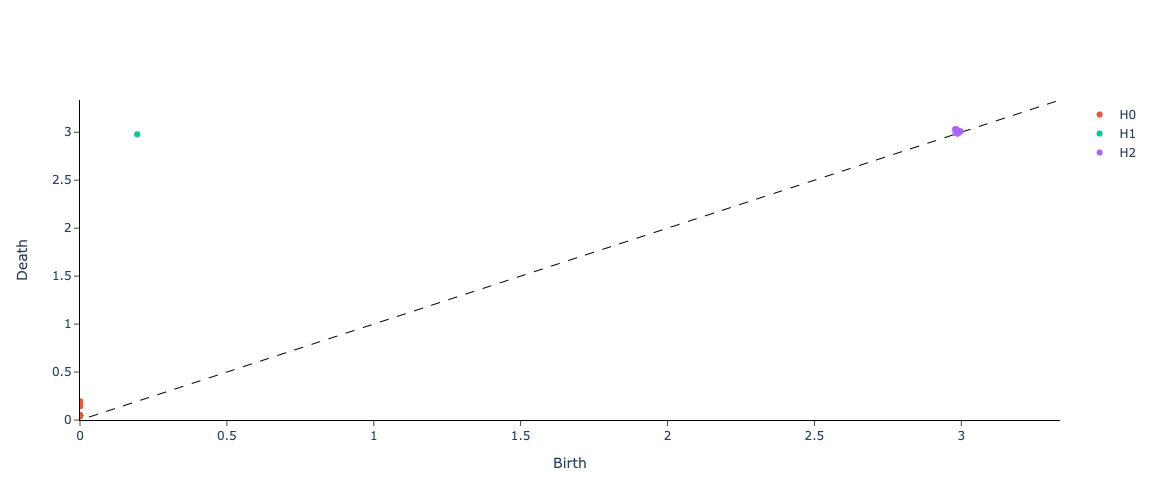

In [ ]:
plot_diagram(periodic_persistence_diagrams[0])

and next for the non-periodic one:

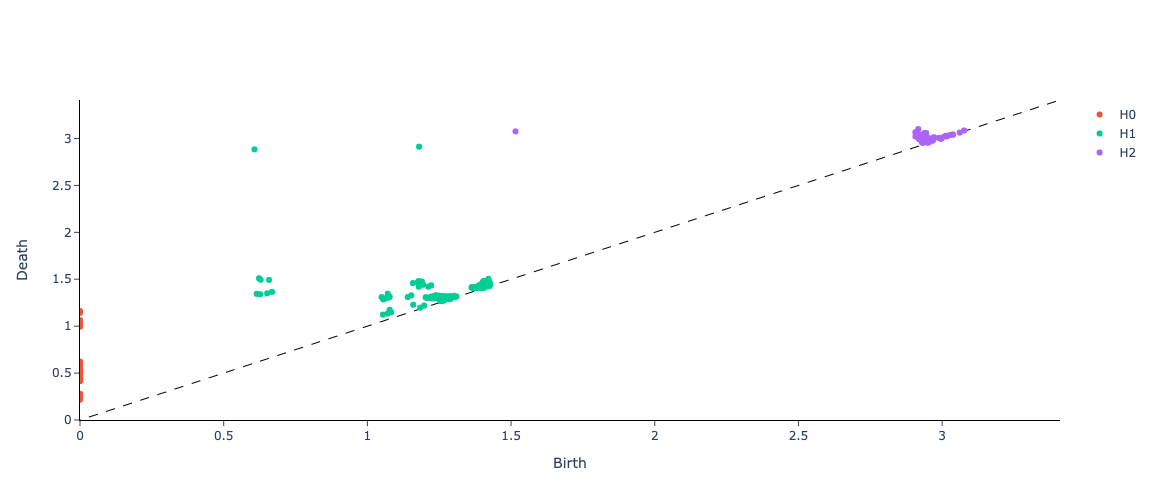

In [ ]:
plot_diagram(nonperiodic_persistence_diagrams[0])

In this case the persistence diagram for the periodic signal is essentially unchanged, but the non-periodic signal now reveals two H1 points and one H2 one - the signature of a hypertorus! It turns out that in general, the image of $SW_{M,\tau}f$ is a hypertorus.

## Gravitational wave detection

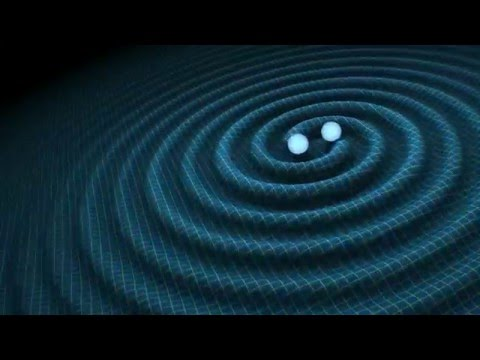

In [ ]:
YouTubeVideo('Y3eR49ogsF0', width=600, height=400)

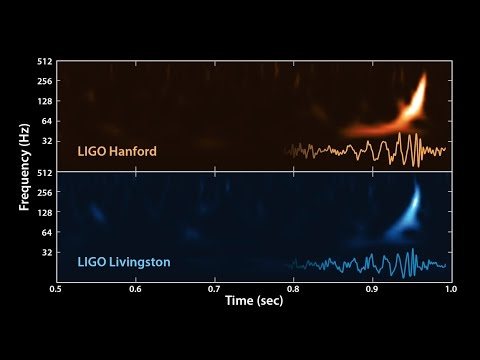

In [ ]:
YouTubeVideo('QyDcTbR-kEA', width=600, height=400)

As an application of the above ideas, let's examine how persistent homology can help detect gravitational waves in noisy signals. The following is adapted form the [article](https://arxiv.org/pdf/1910.08245.pdf) by C. Bresten and J.H. Jung.

### Generate the data

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

In [ ]:
DATA = Path("../data")

In [ ]:
def make_gravitational_waves(
    path_to_data: Path = DATA,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load(DATA / "gravitational-wave-signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    ri = []
    k = 0
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    x = []
    noisy_signals = []
    gw_signals = []
    y = []
    pcloud = []
    maxs = 0.0
    k = 0
    y = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][0][range(0, Norig, downsample_factor)] #gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        y[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, y

### Constant signal-to-noise ratio

As a warmup, let's generate some noisy signals with a constant signal-to-noise ratio (SNR) of 8.523. 

In [ ]:
R = 1.

noisy_signals, gw_signals, labels = make_gravitational_waves(n_signals=100, downsample_factor=2, r_min=R, r_max=R, n_snr_values=10)

print(f'Number of noisy signals: {len(noisy_signals)}')
print(f'Number of timesteps per series: {len(noisy_signals[0])}')

Number of noisy signals: 100
Number of timesteps per series: 8692


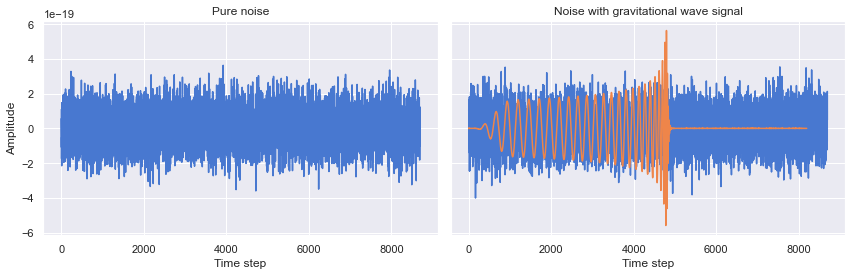

In [ ]:
background_idx = np.argmin(labels)
signal_idx =  np.argmax(labels)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,4), sharey=True)

ax0.plot(noisy_signals[background_idx])
ax0.set_ylabel('Amplitude')
ax0.set_xlabel('Time step')
ax0.set_title('Pure noise')

ax1.plot(noisy_signals[1])
ax1.plot(gw_signals[signal_idx])
ax1.set_xlabel('Time step')
ax1.set_title('Noise with gravitational wave signal')

plt.tight_layout()

Let's examine what the sliding window embedding of a pure gravitational wave signal looks like:

In [ ]:
embedder = TakensEmbedding()

embedding_dimension = 30
embedding_time_delay = 30

embedder = TakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=5
)

%time y_gw_embedded = fit_embedder(embedder, gw_signals[0])

Shape of embedded time series: (784, 12)
Optimal embedding dimension is 12 and time delay is 16
CPU times: user 44.8 ms, sys: 6.48 ms, total: 51.3 ms
Wall time: 143 ms


As we did in our simple examples, we can use PCA to project our high-dimensional space to 3-dimensions for visualisation:

In [ ]:
pca = PCA(n_components=3)
y_gw_embedded_pca = pca.fit_transform(y_gw_embedded)

plot_point_cloud(y_gw_embedded_pca)

From the plot we can see that the decaying periodic signal generated by a black hole merger emerges as a spiral in the sliding window embedding space. For contrast, let's compare this to one of the pure noise time series in our sample:

In [ ]:
embedder = TakensEmbedding()

embedding_dimension = 30
embedding_time_delay = 30

embedder = TakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=5
)

y_noise_embedded = fit_embedder(embedder, noisy_signals[background_idx])

pca = PCA(n_components=3)
y_noise_embedded_pca = pca.fit_transform(y_noise_embedded)

plot_point_cloud(y_noise_embedded_pca)

Shape of embedded time series: (892, 6)
Optimal embedding dimension is 6 and time delay is 28


Evidently pure noise resembles a high-dimensional ball in the sliding window embedding space. Let's see if we can use persistent homology to tease classify which time series contain a gravitational wave signal versus those that don't.

In [ ]:
embedding_dimension = 200
embedding_time_delay = 10

point_clouds = []
emb_dims = []
t_delays = []

for i in range(len(noisy_signals)):

    embedder = TakensEmbedding(
        parameters_type="fixed", n_jobs=8, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=10
    )

    pca = PCA(n_components=3)
    point_clouds.append(pca.fit_transform(fit_embedder(embedder, noisy_signals[i], verbose=False)))
    emb_dims.append(embedder.dimension_)
    t_delays.append(embedder.time_delay_)

point_clouds = np.asarray(point_clouds)
point_clouds.shape

(100, 671, 3)

In [ ]:
homology_dimensions = [0, 1]

persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
%time persistence_diagrams = persistence.fit_transform(point_clouds)

CPU times: user 174 ms, sys: 19.9 ms, total: 194 ms
Wall time: 6.73 s


In [ ]:
scaled_dgms = Scaler().fit_transform(persistence_diagrams)

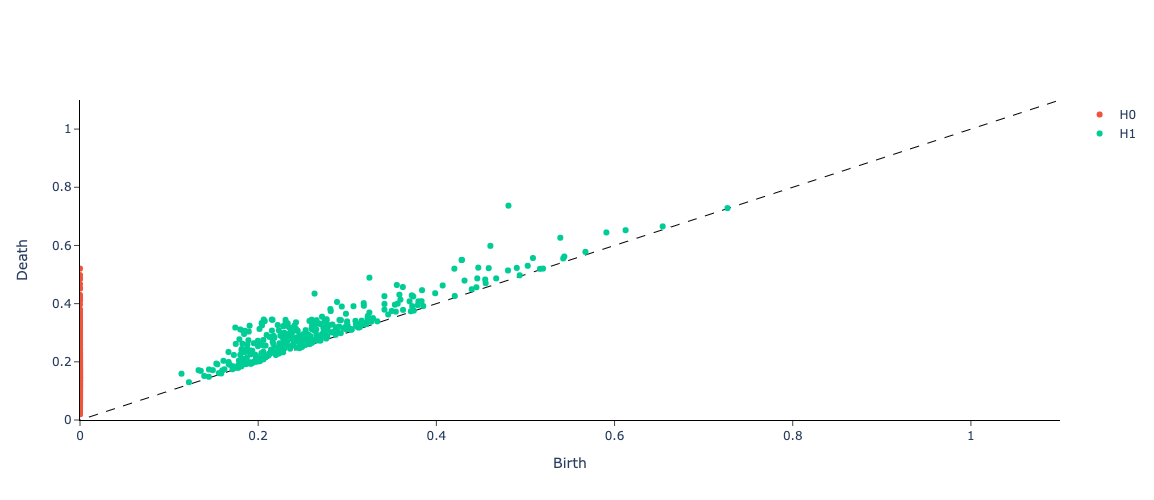

In [ ]:
plot_diagram(scaled_dgms[background_idx])

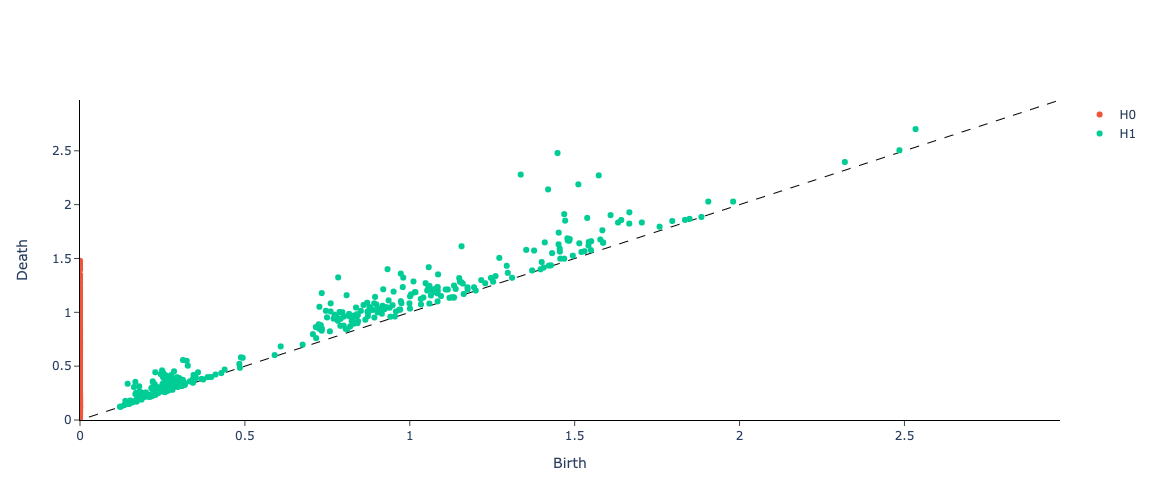

In [ ]:
plot_diagram(scaled_dgms[signal_idx])

In [ ]:
persistent_entropy = PersistenceEntropy()

X = persistent_entropy.fit_transform(scaled_dgms)
X.shape

(100, 2)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, labels, test_size=0.1, random_state=42)

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=42)
rf.fit(X_train, y_train)
# score
rf.score(X_valid, y_valid)

1.0

In [ ]:
roc_auc_score(y_valid, rf.predict_proba(X_valid)[:, 1])

1.0

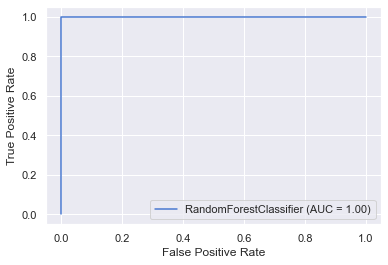

In [ ]:
plot_roc_curve(rf, X_valid, y_valid)